In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import cv2
import os
from sklearn.model_selection import train_test_split

In [21]:
# Define paths
train_dir = "/Users/krishnadhiman/Downloads/archive/train"
test_dir = "/Users/krishnadhiman/Downloads/archive/test"

In [22]:
# Label names mapping
label_names = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
label_map = {label: index for index, label in enumerate(label_names)}

In [23]:
# Load the data
def load_data(data_dir, img_size=(48, 48)):
    images = []
    labels = []
    
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        if os.path.isdir(label_dir):
            for img_name in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:  # Check if the image was loaded successfully
                    img = cv2.resize(img, img_size)
                    images.append(img)
                    
                    if label in label_map:
                        labels.append(label_map[label])
                    else:
                        print(f"Warning: Label '{label}' not found in label map.")
                else:
                    print(f"Warning: Image '{img_path}' could not be loaded.")
    
    images = np.array(images)
    labels = np.array(labels)
    
    images = images.astype('float32') / 255.0
    images = np.expand_dims(images, axis=-1)
    labels = to_categorical(labels, num_classes=len(label_names))
    
    return images, labels

In [24]:
# Load the dataset
train_images, train_labels = load_data(train_dir)
test_images, test_labels = load_data(test_dir)

In [25]:
# Split the training data into train and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)


In [26]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [27]:
# Model Architecture - Increase depth and filters
model = models.Sequential([
    layers.Input(shape=(48, 48, 1)),
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.4),
    layers.Dense(len(label_names), activation='softmax')
])

2025-01-07 12:35:05.049458: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-01-07 12:35:05.049479: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-01-07 12:35:05.049482: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-01-07 12:35:05.049638: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-07 12:35:05.049647: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [28]:
# Compile the model with Adam optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


In [33]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-7, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

In [42]:
# Fit the model with the augmented data
history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=64),
    epochs=100,
    validation_data=(val_images, val_labels),
    callbacks=[early_stopping, lr_reduction, model_checkpoint]
)

Epoch 1/100


/Users/krishnadhiman/Downloads/AIML project/tfvenv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2186 - loss: 2.6412
Epoch 1: val_loss improved from inf to 2.83431, saving model to best_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.2187 - loss: 2.6407 - val_accuracy: 0.1987 - val_loss: 2.8343 - learning_rate: 0.0010
Epoch 2/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2819 - loss: 2.2423
Epoch 2: val_loss improved from 2.83431 to 2.03943, saving model to best_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.2820 - loss: 2.2421 - val_accuracy: 0.3377 - val_loss: 2.0394 - learning_rate: 0.0010
Epoch 3/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3442 - loss: 2.0205
Epoch 3: val_loss improved from 2.03943 to 1.97347, saving model to best_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.3442 - loss: 2.0204 - val_accuracy: 0.3706 - val_loss: 1.9735 - learning_rate: 0.0010
Epoch 4/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.

In [43]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")


225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7070 - loss: 0.8911
Test accuracy: 0.6214823126792908
Test loss: 1.1053149700164795


In [54]:
# Save the model
model.save('facial_expression_model.keras')

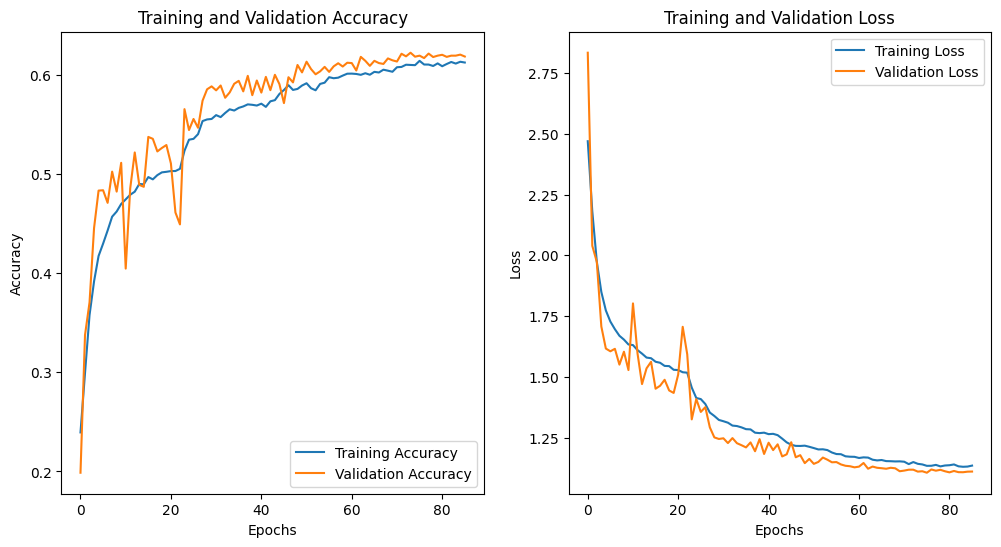

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Plotting Training and Validation Accuracy
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [45]:
# Confusion Matrix
test_predictions = np.argmax(model.predict(test_images), axis=-1)
test_labels_true = np.argmax(test_labels, axis=-1)

cm = confusion_matrix(test_labels_true, test_predictions)

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


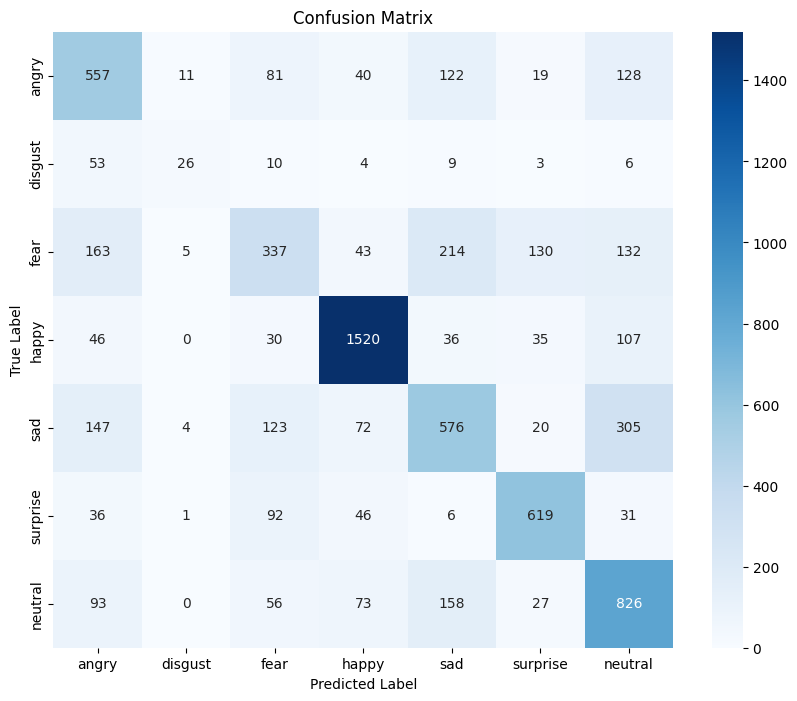

In [46]:
# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [74]:
#classification metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 0.62
Precision: 0.62
Recall: 0.62
F1-score: 0.61


In [2]:
import cv2
import numpy as np
import pyttsx3
import webbrowser
import time
from keras.models import load_model
import random
import subprocess
import sys

In [3]:
# Initialize pyttsx3 for speech output
engine = pyttsx3.init()

In [4]:
# Load the emotion detection model 
emotion_model = load_model('facial_expression_model.keras')

2025-01-07 18:12:25.827651: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-01-07 18:12:25.827670: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-01-07 18:12:25.827673: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-01-07 18:12:25.827804: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-07 18:12:25.827812: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
# Emotion labels based on the model 
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [6]:
emotion_youtube = {
    'Angry': [
        'https://www.youtube.com/watch?v=-Yd1iOsreK0',  # Beat Me: By Above Envy
        'https://www.youtube.com/watch?v=YHs7ju2KzDs',  # No Filter - Neffex
        'https://www.youtube.com/watch?v=q8IWMnrXbG0',  # Main Nai Tuttna - Attack
        'https://www.youtube.com/watch?v=0gK1SHLtaOo',  # MILA TOH MAREGA
        'https://www.youtube.com/watch?v=Ax0G_P2dSBw',  # Zinda - Bhaag Milkha Bhaag
        'https://www.youtube.com/watch?v=9iIX4PBplAY',  # Kar Har Maidaan Fateh - Sanju
        'https://www.youtube.com/watch?v=abiL84EAWSY',  # Sultan Title Track
        'https://www.youtube.com/watch?v=h6aGikIL-I4'   # Get Ready to Fight - Baaghi
    ],
    'Happy': [
        'https://www.youtube.com/watch?v=fdubeMFwuGs',  # Ilahi
        'https://www.youtube.com/watch?v=KWCLOpaZeLc',  # Tumse Hi Tumse
        'https://www.youtube.com/watch?v=jCEdTq3j-0U',  # Gallan Goodiyan
        'https://www.youtube.com/watch?v=AEIVhBS6baE',  # Pritam - Gerua
        'https://www.youtube.com/watch?v=OulN7vTDq1I',  # DJ Wale Babu
        'https://www.youtube.com/watch?v=WuMWwPHTSoY',  # Dil Dhadakne Do - Zindagi Na Milegi Dobara
        'https://www.youtube.com/watch?v=1YBl3Zbt80A',  # Badri Ki Dulhania
        'https://www.youtube.com/watch?v=HgIW7P4dsXU'   # Nachde Ne Saare - Baar Baar Dekho
    ],
    'Sad': [
        'https://www.youtube.com/watch?v=PVxc5mIHVuQ',  # Pachtaoge
        'https://www.youtube.com/watch?v=_iktURk0X-A',  # Phir Bhi Tumko Chaahunga
        'https://www.youtube.com/watch?v=2JBYnvUlAEcE', # Dhokha Song
        'https://www.youtube.com/watch?v=xRb8hxwN5zc',  # Kal Ho Naa Ho
        'https://www.youtube.com/watch?v=EatzcaVJRMs',  # Tera Yaar Hoon Main
        'https://www.youtube.com/watch?v=IJq0yyWug1k',  # Tum Hi Ho - Aashiqui 2
        'https://www.youtube.com/watch?v=MJyKN-8UncM',  # Shayad - Love Aaj Kal
        'https://www.youtube.com/watch?v=284Ov7ysmfA'   # Channa Mereya
    ],
    'Neutral': [
        'https://www.youtube.com/watch?v=R4YeD7aoOmU',  # Phir Le Aya Dil
        'https://www.youtube.com/watch?v=SAcpESN_Fk4',  # Dil Diyan Gallan
        'https://www.youtube.com/watch?v=TFr6G5zveS8',  # Lag Jaa Gale
        'https://www.youtube.com/watch?v=po6kjouyxXg',  # Mere Sapno Ki Rani
        'https://www.youtube.com/watch?v=Qdz5n1Xe5Qo',  # Tera Ban Jaunga
        'https://www.youtube.com/watch?v=atVof3pjT-I',  # Kaun Tujhe - MS Dhoni
        'https://www.youtube.com/watch?v=qpIdoaaPa6U',  # Jeene Laga Hoon - Ramaiya Vastavaiya
        'https://www.youtube.com/watch?v=odVptmgIcD0'   # Tum Mile
    ],
    'Surprise': [
        'https://www.youtube.com/watch?v=IFP3Jc5ztgg',  # Tunak Tunak Tun
        'https://www.youtube.com/watch?v=ijGumwamEQU',  # Jumma Chumma
        'https://www.youtube.com/watch?v=LYEqeUr-158',  # Sauda Khara Khara
        'https://www.youtube.com/watch?v=yN21C972fsE',  # Oh Ho Ho Ho - Hindi Medium
        'https://www.youtube.com/watch?v=oCBDl58lBoU',  # Bala - Housefull 4
        'https://www.youtube.com/watch?v=52deq20h6Q4',  # Radha - Student of the Year
        'https://www.youtube.com/watch?v=NTHz9ephYTw',  # Kar Gayi Chull - Kapoor & Sons
        'https://www.youtube.com/watch?v=8LZgzAZ2lpQ'   # Abhi Toh Party Shuru Hui Hai - Khoobsurat
    ],
    'Fear': [
        'https://www.youtube.com/watch?v=g0eO74UmRBs',  # Kal Ho Naa Ho
        'https://www.youtube.com/watch?v=yVImQoGNdTE',  # Yaar Bina
        'https://www.youtube.com/watch?v=iasxMdSu7Jo',  # Jiya Dhadak Dhadak Jaye
        'https://www.youtube.com/watch?v=KzBa4ZKTVjE',  # Naina - Dangal
        'https://www.youtube.com/watch?v=6FURuLYrR_Q',  # Ae Dil Hai Mushkil Title Track
        'https://www.youtube.com/watch?v=hoNb6HuNmU0',  # Khairiyat - Chhichhore
        'https://www.youtube.com/watch?v=-y6_cFZsMJA',  # Zindagi Kaisi Hai Paheli - Anand
        'https://www.youtube.com/watch?v=HsQYlZEtKX4'   # Sandese Aate Hain - Border
    ],
    'Disgust': [
        'https://www.youtube.com/watch?v=MXJCnccDLA0',  # Aaj Blue Hai Paani
        'https://www.youtube.com/watch?v=Jn5hsfbhWx4',  # Munni Badnaam Hui
        'https://www.youtube.com/watch?v=52deq20h6Q4',  # Radha - Student of the Year
        'https://www.youtube.com/watch?v=zE7Pwgl6sLA',  # Fevicol Se - Dabangg 2
        'https://www.youtube.com/watch?v=TITGBTGJZS8',  # Selfie Le Le Re - Bajrangi Bhaijaan
        'https://www.youtube.com/watch?v=p6D8u6lEDjQ',  # Dhinka Chika - Ready
        'https://www.youtube.com/watch?v=sONw3dihCRs',  # Anarkali Disco Chali - Housefull 2
        'https://www.youtube.com/watch?v=ZTmF2v59CtI'   # Sheila Ki Jawani - Tees Maar Khan
    ]
}


In [7]:
# Function to predict the emotion from the image
def predict_emotion(face_image):
    # Preprocess the image
    face_image = cv2.resize(face_image, (48, 48)) 
    face_image = face_image.astype('float32') / 255.0 
    face_image = np.expand_dims(face_image, axis=0) 

    # Predict emotion
    emotion_prediction = emotion_model.predict(face_image)

    # Get the emotion with the highest probability
    max_index = np.argmax(emotion_prediction[0])
    predicted_emotion = emotion_labels[max_index]

    return predicted_emotion

In [8]:
# Function to speak the detected emotion
def speak_emotion(emotion):
    engine.say(f"The detected emotion is {emotion}")
    engine.runAndWait()

# Start the webcam feed
cap = cv2.VideoCapture(0)
start_time = time.time()
recognized_emotion = None

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Load the pre-trained Haar Cascade Classifier for face detection
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Variable to store the emotion of the first face
    detected_emotions = []

    # For each detected face
    for (x, y, w, h) in faces:
        face = gray[y:y+h, x:x+w]

        # Predict the emotion for the detected face
        emotion = predict_emotion(face)
        detected_emotions.append(emotion)

        # Draw a rectangle around the face and label the emotion
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(frame, emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Update recognized_emotion only after all faces are processed
    if len(detected_emotions) > 0:
        recognized_emotion = detected_emotions[0]

    # Display the frame
    cv2.imshow('Emotion Detection', frame)

    # Check if 5 seconds have passed (stop after 5 seconds)
    if time.time() - start_time > 5:
        break

    # Exit the loop when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Close the camera feed
cap.release()
cv2.destroyAllWindows()

# Speak the detected emotion
if recognized_emotion:
    print(f"Detected Emotion: {recognized_emotion}")  # Debugging output
    speak_emotion(recognized_emotion)

    # Open a random YouTube link corresponding to the detected emotion
    if recognized_emotion in emotion_youtube:
        selected_video = random.choice(emotion_youtube[recognized_emotion]) 
        print(f"Opening YouTube link: {selected_video}")  # Debugging output
        webbrowser.open(selected_video)
       
# End the program
print("Emotion detected:", recognized_emotion)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


2025-01-07 18:12:27.828785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2025-01-07 18:12:28.305 Python[22261:626091] +[IMKClient subclass]: chose IMKClient_Modern
2025-01-07 18:12:28.305 Python[22261:626091] +[IMKInputSession subclass]: chose IMKInputSession_Modern


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1